# Model with conditional interaction

In this example, we show global effects of a model with general form interactions using PDP, ALE, and RHALE.
In particular, we:

1. show how to use `effector` to estimate the global effects using PDP, ALE, and RHALE
2. provide the analytical formulas for the global effects
3. test that (1) and (2) match

We will use the following function:

$$
f(x_1, x_2, x_3) = x_1 x_2^2 + e^{x_3}
$$

where the features $x_1$, $x_2$, and $x_3$ are independent and uniformly distributed in the interval $[-1, 1]$.

The model contains an interaction between $x_1$ and $x_2$ caused by the term:

$$
f_{1,2}(x_1, x_2) = x_1 x_2^2.
$$

This means that the effect of $x_1$ on the output depends on the value of $x_2$, and vice versa. Consequently, there is no universally agreed-upon way to separate the effect of $f_{1,2}$ into two components: one that corresponds solely to $x_1$ and one solely to $x_2$. Different global effect methods (such as PDP, ALE, and RHALE) adopt different strategies to handle this interaction.

In contrast, $x_3$ does not interact with any other feature, so its effect can be easily computed as $e^{x_3}$.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import effector

np.random.seed(21)

model = effector.models.GeneralInteraction()
dataset = effector.datasets.IndependentUniform(dim=3, low=-1, high=1)
x = dataset.generate_data(1_000)

## PDP

### Effector

Let's see below the PDP effects for each feature, using `effector`.

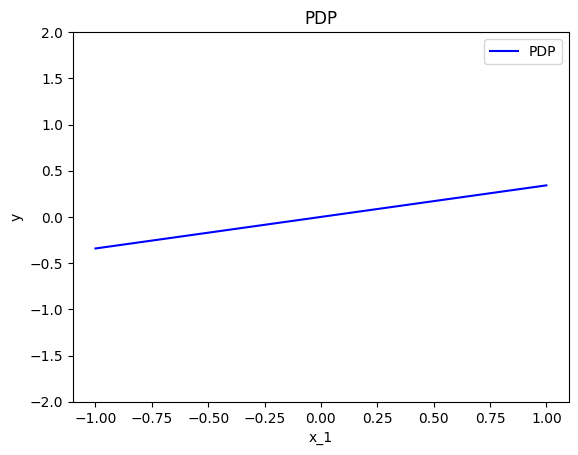

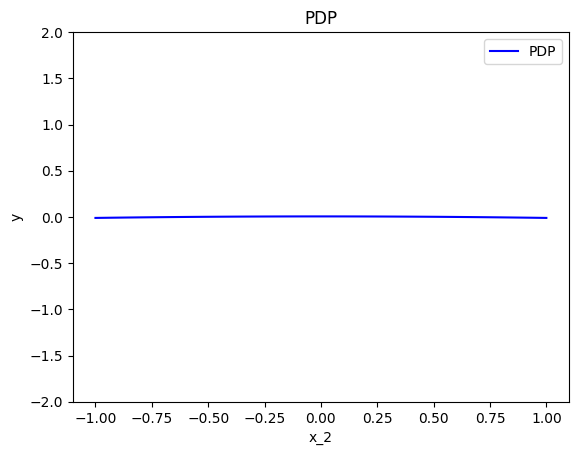

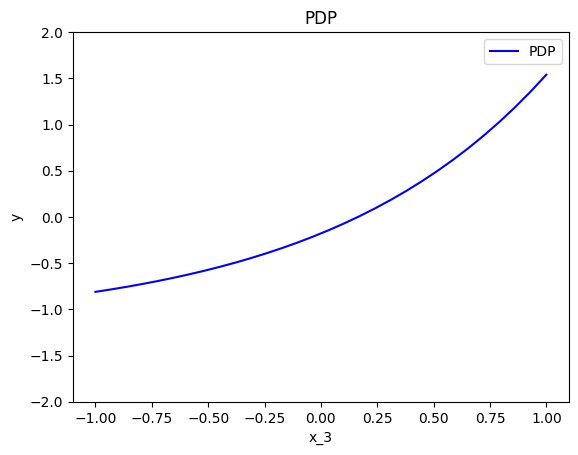

In [2]:
pdp = effector.PDP(x, model.predict, dataset.axis_limits)
pdp.fit(features="all", centering=True)
for feature in [0, 1, 2]:
    pdp.plot(feature=feature, centering=True, y_limits=[-2, 2])

PDP states that:

* $x_1$ has an average effect proportional to $\frac{1}{3} x_1$ on the model output.
* $x_2$ has a constant effect on the model output due to $x_2^2$, which is symmetric about $x_2 = 0$. 
* $x_3$ has an effect of $e^{x_3}$.


### Derivations

How PDP leads to these explanations? Are they meaningfull? Let's have some analytical derivations.
If you don't care about the derivations, skip the following three cells and go directly to the coclusions.

For $x_1$:

\begin{align}
PDP(x_1) &\propto \frac{1}{N} \sum_{i=1}^{N} f(x_1, \mathbf{x}^i_{/1}) \\
&\propto \frac{1}{N} \sum_{i=1}^{N} \left( x_1 x_2^{i,2} + e^{x_3^i} \right) \\
&\propto x_1 \cdot \frac{1}{N} \sum_{i=1}^{N} x_2^{i,2} + \frac{1}{N} \sum_{i=1}^{N} e^{x_3^i} \\
&\propto x_1 \cdot \mathbb{E}[x_2^2] + c,
\end{align}

where $\mathbb{E}[x_2^2] = \frac{1}{3}$ for $x_2 \sim \mathcal{U}(-1, 1)$ and $c$ is the constant contribution from $e^{x_3}$. Therefore:

$$
PDP(x_1) = \frac{1}{3} x_1 + c.
$$


For $x_2$:

\begin{align}
PDP(x_2) &\propto \frac{1}{N} \sum_{i=1}^{N} f(x_2, \mathbf{x}_{/2}^i) \\
&\propto \frac{1}{N} \sum_{i=1}^{N} \left( x_1^i (x_2)^2 + e^{x_3^i} \right) \\
&\propto \left( x_2^2 \cdot \frac{1}{N} \sum_{i=1}^{N} x_1^i \right) + \frac{1}{N} \sum_{i=1}^{N} e^{x_3^i}.
\end{align}

Since $\frac{1}{N} \sum_{i=1}^{N} x_1^i = 0$ for $x_1 \sim \mathcal{U}(-1, 1)$:
$$
PDP(x_2) \propto \mathbb{E}[e^{x_3}].
$$

Thus:
$$
PDP(x_2) = c,
$$

where $c$ is the constant contribution from $e^{x_3}$.


For $x_3$:

\begin{align}
PDP(x_3) &\propto \frac{1}{N} \sum_{i=1}^{N} f(x_3, \mathbf{x}_{/3}^i) \\
&\propto \frac{1}{N} \sum_{i=1}^{N} \left( x_1^i (x_2^i)^2 + e^{x_3} \right) \\
&\propto \frac{1}{N} \sum_{i=1}^{N} x_1^i (x_2^i)^2 + e^{x_3}.
\end{align}

Since $\frac{1}{N} \sum_{i=1}^{N} x_1^i (x_2^i)^2 = 0$ (as $x_1$ and $(x_2^i)^2$ are independent, and $\mathbb{E}[x_1] = 0$):
$$
PDP(x_3) \propto e^{x_3}.
$$

Thus:
$$
PDP(x_3) = e^{x_3}.
$$


### Conclusions

Are the PDP effects intuitive?

* For $x_1$, the effect is proportional to $\frac{1}{3} x_1$. The term $x_1 x_2^2$ involves an interaction with $x_2$, but since $x_2^2 \sim \mathcal{U}([0,1])$, the interaction averages out uniformly, leaving a proportional effect of $\frac{1}{3} x_1$.
* For $x_2$, the effect is constant because $x_2^2$ is symmetric about $x_2 = 0$. Since $x_2^2$ contributes positively and does not depend on the sign of $x_2$, the PDP reflects only the additive constant contribution from $e^{x_3}$.
* For $x_3$, the effect is $e^{x_3}$, as expected, since this term directly corresponds to $x_3$ and has no interaction with other variables.


In [3]:
def compute_centering_constant(func, start, stop, nof_points):
    x = np.linspace(start, stop, nof_points)
    y = func(x)
    return np.mean(y)

def pdp_ground_truth(feature, xs):
    if feature == 0:  
        func = lambda x: (1/3) * x  
        z = compute_centering_constant(func, -1, 1, 1000)
        return func(xs) - z
    elif feature == 1:  
        func = lambda x: np.zeros_like(x)  
        z = compute_centering_constant(func, -1, 1, 1000)
        return func(xs) - z
    elif feature == 2:  
        func = lambda x: np.exp(x)  
        z = compute_centering_constant(func, -1, 1, 1000)
        return func(xs) - z

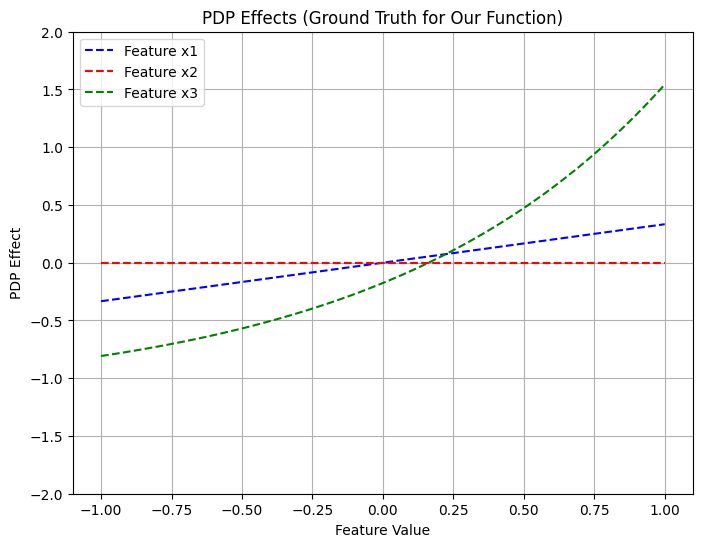

In [4]:
xx = np.linspace(-1, 1, 100)
y_pdp = []

for feature in [0, 1, 2]:
    y_pdp.append(pdp_ground_truth(feature, xx))

plt.figure(figsize=(8, 6))
plt.title("PDP Effects (Ground Truth for Our Function)")
color_palette = ["blue", "red", "green"]
feature_labels = ["Feature x1", "Feature x2", "Feature x3"]
for feature in [0, 1, 2]:
    plt.plot(
        xx,
        y_pdp[feature],
        color=color_palette[feature],
        linestyle="--",
        label=feature_labels[feature],
    )

plt.legend()
plt.xlim([-1.1, 1.1])
plt.ylim([-2, 2])
plt.xlabel("Feature Value")
plt.ylabel("PDP Effect")
plt.grid(True)
plt.show()

In [5]:
# make a test
xx = np.linspace(-1, 1, 100)
for feature in [0, 1, 2]:
    y_pdp = pdp.eval(feature=feature, xs=xx, centering=True)
    y_gt = pdp_ground_truth(feature, xx)
    np.testing.assert_allclose(y_pdp, y_gt, atol=1e-1)

## ALE

### Effector

Let's see below the PDP effects for each feature, using `effector`.

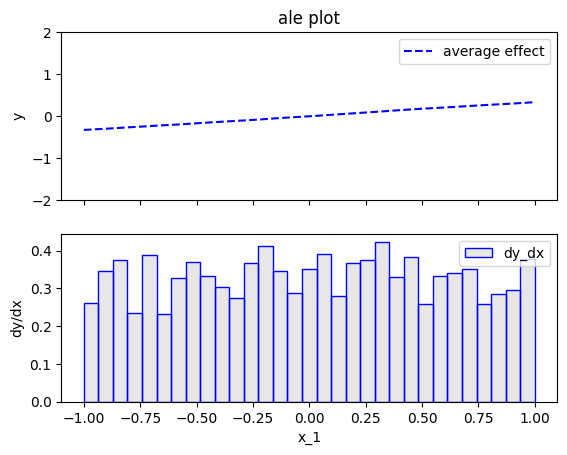

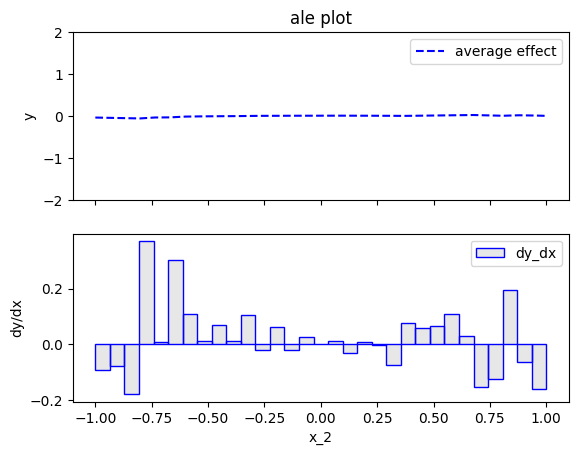

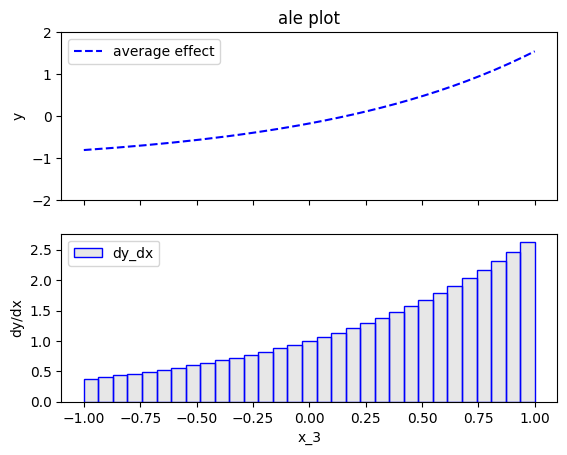

In [6]:
ale = effector.ALE(x, model.predict, axis_limits=dataset.axis_limits)
ale.fit(features="all", centering=True, binning_method=effector.binning_methods.Fixed(nof_bins=31))

for feature in [0, 1, 2]:
    ale.plot(feature=feature, centering=True, y_limits=[-2, 2])

ALE states that:

- For \(x_1\): The ALE effect is proportional to \(\frac{1}{3} x_1\). This reflects the linear relationship between \(x_1\) and the model output, averaged over the distribution of \(x_2\). The result aligns with the PDP, as the average effect of \(x_2^2\) on \(x_1\) remains consistent.

- For \(x_2\): The ALE effect is constant, as \(x_2^2\) contributes symmetrically to the model output. This results in no variation with \(x_2\), and the effect is consistent with the PDP. The interaction terms cancel out on average, leaving only the baseline constant.

- For \(x_3\): The ALE effect is \(e^{x_3}\), reflecting the direct contribution of the exponential term \(e^{x_3}\) in the model. This is identical to the PDP effect since \(x_3\) does not interact with other features.


ALE states that:
- For \(x_1\): The effect is proportional to $\frac{1}{3} x_1$, matching the PDP.
- For \(x_2\): The effect is constant due to the symmetric contribution of $x_2^2$, consistent with the PDP.
- For \(x_3\): The effect is $e^{x_3}$, identical to the PDP.


### Derivations

\begin{align}
ALE(x_1) &\propto \sum_{k=1}^{k_{x_1}} \frac{1}{| \mathcal{S}_k |} \sum_{i: x^i \in \mathcal{S}_k} \left[ f(z_k, x^i_2, x^i_3) - f(z_{k-1}, x^i_2, x^i_3) \right] \\
&\propto \sum_{k=1}^{k_{x_1}} \frac{1}{| \mathcal{S}_k |} \sum_{i: x^i \in \mathcal{S}_k} \left[ z_k x_2^{i,2} + e^{x_3^i} - (z_{k-1} x_2^{i,2} + e^{x_3^i}) \right] \\
&\propto \sum_{k=1}^{k_{x_1}} \frac{1}{| \mathcal{S}_k |} \sum_{i: x^i \in \mathcal{S}_k} \left[ (z_k - z_{k-1}) x_2^{i,2} \right].
\end{align}

Since $x_2^{i,2} \sim \mathcal{U}([0, 1])$, its expected value is:

\begin{align}
\mathbb{E}[x_2^2] &= \frac{1}{3}.
\end{align}

Thus:

\begin{align}
ALE(x_1) &\propto (z_k - z_{k-1}) \cdot \mathbb{E}[x_2^2] \\
&= \frac{1}{3} x_1.
\end{align}


\begin{align}
ALE(x_2) &\propto \sum_{k=1}^{k_{x_2}} \frac{1}{| \mathcal{S}_k |} \sum_{i: x^i \in \mathcal{S}_k} \left[ f(x^i_1, z_k, x^i_3) - f(x^i_1, z_{k-1}, x^i_3) \right] \\
&\propto \sum_{k=1}^{k_{x_2}} \frac{1}{| \mathcal{S}_k |} \sum_{i: x^i \in \mathcal{S}_k} \left[ x_1^i z_k^2 + e^{x_3^i} - (x_1^i z_{k-1}^2 + e^{x_3^i}) \right] \\
&\propto \sum_{k=1}^{k_{x_2}} \frac{1}{| \mathcal{S}_k |} \sum_{i: x^i \in \mathcal{S}_k} \left[ x_1^i (z_k^2 - z_{k-1}^2) \right].
\end{align}

Since $x_1^i \sim \mathcal{U}(-1, 1)$, its expected value is zero:

\begin{align}
\mathbb{E}[x_1] &= 0.
\end{align}

Thus:

\begin{align}
ALE(x_2) &\propto 0.
\end{align}


\begin{align}
ALE(x_3) &\propto \sum_{k=1}^{k_{x_3}} \frac{1}{| \mathcal{S}_k |} \sum_{i: x^{(i)} \in \mathcal{S}_k} \left [  f(x^i_1, x^i_2, z_k) - f(x^i_1, x^i_2, z_{k-1}) \right ] \\
&\propto \sum_{k=1}^{k_{x_3}} \frac{1}{| \mathcal{S}_k |} \sum_{i: x^{(i)} \in \mathcal{S}_k} \left [ e^{z_k} - e^{z_{k-1}} \right ] \\
&\approx e^{x_3}
\end{align}

In [7]:
def ale_ground_truth(feature, xs):
    if feature == 0:  
        ff = lambda x: (1 / 3) * x  
        z = compute_centering_constant(ff, -1, 1, 1000)
        return ff(xs) - z
    elif feature == 1:  
        ff = lambda x: np.zeros_like(x)  
        z = compute_centering_constant(ff, -1, 1, 1000)
        return ff(xs) - z
    elif feature == 2:  
        ff = lambda x: np.exp(x)  
        z = compute_centering_constant(ff, -1, 1, 1000)
        return ff(xs) - z


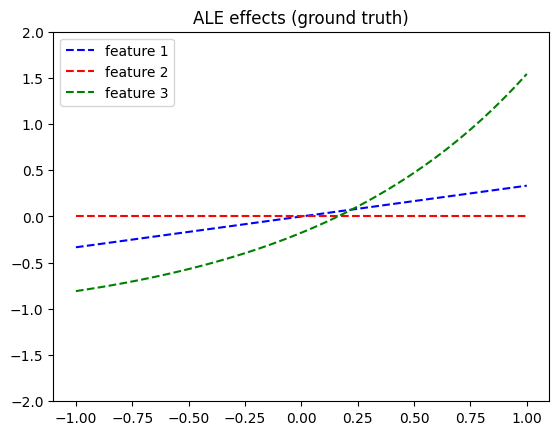

In [8]:
xx = np.linspace(-1, 1, 100)
y_ale = []
for feature in [0, 1, 2]:
    y_ale.append(ale_ground_truth(feature, xx))
    
plt.figure()
plt.title("ALE effects (ground truth)")
color_pallette = ["blue", "red", "green"]
for feature in [0, 1, 2]:
    plt.plot(
        xx, 
        y_ale[feature], 
        color=color_pallette[feature], 
        linestyle="--",
        label=f"feature {feature + 1}"
    )
plt.legend()
plt.xlim([-1.1, 1.1])
plt.ylim([-2, 2])
plt.show()
    

In [9]:
xx = np.linspace(-1, 1, 100)
for feature in [0, 1, 2]:
    y_ale = ale.eval(feature=feature, xs=xx, centering=True)
    y_gt = ale_ground_truth(feature, xx)
    
    # hack to remove the effect at undefined region
    if feature == 1:
        K = 31
        ind = np.logical_and(xx > -1/K, xx < 1/K)
        y_ale[ind] = 0
        y_gt[ind] = 0
    
    np.testing.assert_allclose(y_ale, y_gt, atol=1e-1)
    

### Conclusions

Are the ALE effects intuitive?

ALE effects are identical to PDP effects which, as discussed above, can be considered intutive.

## RHALE

### Effector

Let's see below the RHALE effects for each feature, using `effector`.

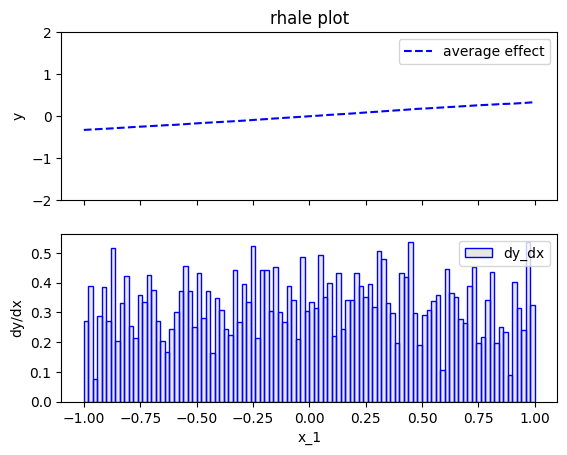

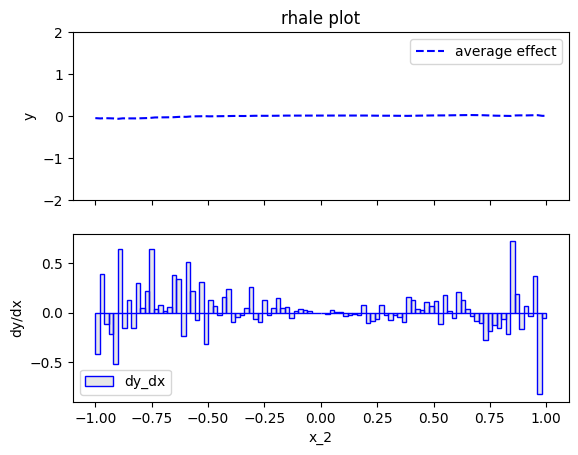

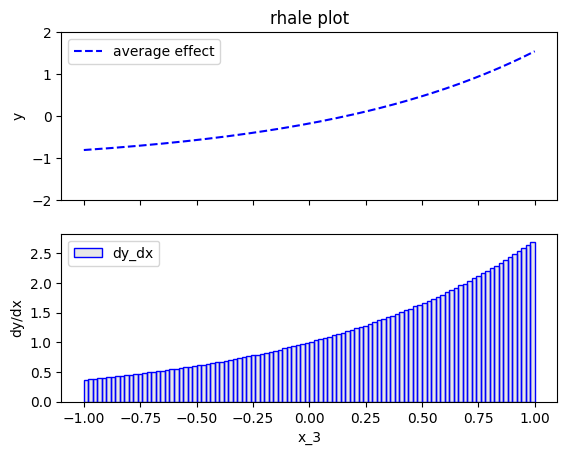

In [10]:
rhale = effector.RHALE(x, model.predict, model.jacobian, axis_limits=dataset.axis_limits)
rhale.fit(features="all", centering=True)

for feature in [0, 1, 2]:
    rhale.plot(feature=feature, centering=True, y_limits=[-2, 2])

RHALE states that:
- $x_1$ has a zero average effect on the model output (same as PDP)
- $x_2$ has a zero average effect on the model output (different than PDP and ALE)
- $x_3$ has an effect of $e^{x_3}$ (same as PDP)


### Derivations

\begin{align}
RHALE(x_1) &\propto \sum_{k=1}^{k_{x_1}} \frac{1}{| \mathcal{S}_k |} (z_k - z_{k-1}) \sum_{i: x^i \in \mathcal{S}_k} \left[ \frac{\partial f}{\partial x_1}(\mathbf{x}^i) \right] \\
&\propto \sum_{k=1}^{k_{x_1}} \frac{1}{| \mathcal{S}_k |} (z_k - z_{k-1}) \sum_{i: x^i \in \mathcal{S}_k} \left[ x_2^{i,2} \right].
\end{align}

Since $x_2^{i,2} \sim \mathcal{U}([0, 1])$, its expected value is:

\begin{align}
\mathbb{E}[x_2^2] &= \frac{1}{3}.
\end{align}

Thus:

\begin{align}
RHALE(x_1) &\propto (z_k - z_{k-1}) \cdot \mathbb{E}[x_2^2] \\
&= \frac{1}{3} x_1.
\end{align}


\begin{align}
RHALE(x_2) &\propto \sum_{k=1}^{k_{x_2}} \frac{1}{| \mathcal{S}_k |} (z_k - z_{k-1}) \sum_{i: x^i \in \mathcal{S}_k} \left[ \frac{\partial f}{\partial x_2}(\mathbf{x}^i) \right] \\
&\propto \sum_{k=1}^{k_{x_2}} \frac{1}{| \mathcal{S}_k |} (z_k - z_{k-1}) \sum_{i: x^i \in \mathcal{S}_k} \left[ 2 x_1^i x_2^i \right].
\end{align}

Since $x_1^i \sim \mathcal{U}(-1, 1)$ and $x_2^i \sim \mathcal{U}(-1, 1)$, their expected product is:

\begin{align}
\mathbb{E}[x_1 x_2] &= 0.
\end{align}

Thus:

\begin{align}
RHALE(x_2) &\propto 0.
\end{align}


\begin{align}
RHALE(x_3) &\propto \sum_{k=1}^{k_{x_3}} \frac{1}{| \mathcal{S}_k |} (z_k - z_{k-1}) \sum_{i: x^i \in \mathcal{S}_k} \left [  \frac{\partial f}{\partial x_3}(\mathbf{x}^i) \right ] \\
&\propto \sum_{k=1}^{k_{x_3}} \frac{1}{| \mathcal{S}_k |} (z_k - z_{k-1}) \sum_{i: x^i \in \mathcal{S}_k} \left [ e^{x_3} \right ] \\
&\approx e^{x_3}
\end{align}

In [11]:
def rhale_ground_truth(feature, xs):
    if feature == 0:  
        ff = lambda x: (1 / 3) * x  
        z = compute_centering_constant(ff, -1, 1, 1000)
        return ff(xs) - z
    elif feature == 1:  
        ff = lambda x: np.zeros_like(x)  
        z = compute_centering_constant(ff, -1, 1, 1000)
        return ff(xs) - z
    elif feature == 2: 
        ff = lambda x: np.exp(x) 
        z = compute_centering_constant(ff, -1, 1, 1000)
        return ff(xs) - z


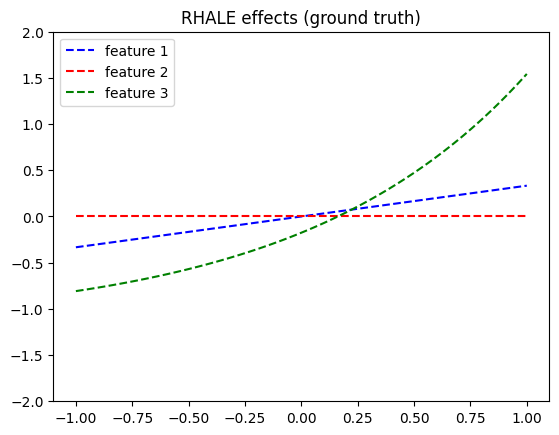

In [12]:
xx = np.linspace(-1, 1, 100)
y_rhale = []
for feature in [0, 1, 2]:
    y_rhale.append(rhale_ground_truth(feature, xx))
    
plt.figure()
plt.title("RHALE effects (ground truth)")
color_pallette = ["blue", "red", "green"]
for feature in [0, 1, 2]:
    plt.plot(
        xx, 
        y_rhale[feature], 
        color=color_pallette[feature], 
        linestyle= "--",
        label=f"feature {feature + 1}"
    )
plt.legend()
plt.xlim([-1.1, 1.1])
plt.ylim([-2, 2])
plt.show()



In [13]:
for feature in [0, 1, 2]:
    y_ale = rhale.eval(feature=feature, xs=xx, centering=True)
    y_gt = rhale_ground_truth(feature, xx)
    np.testing.assert_allclose(y_ale, y_gt, atol=1e-1)

### Conclusions

Are the RHALE effects intuitive?

Since $f(x_1, x_2, x_3)$ is smooth and differentiable with respect to all features, RHALE behaves consistently with ALE and PDP for all features. It correctly captures the linear effect of $x_1$, the symmetric constant contribution of $x_2^2$ as zero, and the exponential effect of $x_3$.
